# Metropolis Algorithm
Kaela Nelson

Volume 3

Lab Objective: Understand the basic principles of the Metropolis algorithm and apply these ideas to the Ising Model. Details on the Metropolis Algorithm and objectives of this lab are found here: http://www.acme.byu.edu/wp-content/uploads/2017/08/Metropolis.pdf .

In [5]:
import numpy as np
from matplotlib import pyplot as plt

## Problem 1

Write a function that accepts an integer $n$ and returns a random spin configuration for an $n \times n$ lattice (as an $n \times n$ NumPy array of $1$s and $-1$s).
Test your function with $n = 100$, plotting the spin configuration via `plt.imshow()`.

In [124]:
def random_lattice(n):
    """Construct a random spin configuration for an nxn lattice."""
    # create lattice, shifted to be in between (-1,1)
    lattice = np.random.binomial(1, .5, size=(n, n))*2 - 1
    return lattice

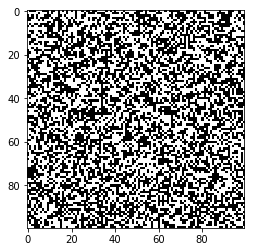

In [125]:
lattice = random_lattice(100)
plt.imshow(lattice,cmap='gray')
plt.show()

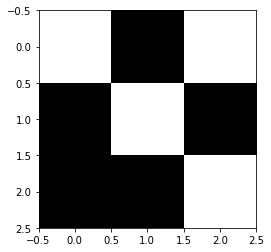

In [126]:
lattice = random_lattice(3)
plt.imshow(lattice,cmap='gray')
plt.show()

## Problem 2

Write a function that accepts a spin configuration $\sigma$ for a lattice as a NumPy array.
Compute the energy $H(\sigma)$ of the spin configuration.
Be careful to not double count site pair interactions!

In [127]:
def lattice_energy(L):
    """Computer the energy of the spin configuration corresponding to the
    lattice L.
    """
    
    # compute energy without overlap
    right = np.roll(L, 1, axis=0)
    top =  np.roll(L, 1, axis=1)

    return -np.sum(L*(right + top))

## Problem 3

Write a function that accepts an integer $n$ and chooses a pair of indices $(i,j)$ where $0 \le i,j \le n-1$.
Each possible pair should have an equal probability $\frac{1}{n^2}$ of being chosen.

In [128]:
def flip_location(n):
    """Choose a random pair of indices 0 <= i,j <= n-1."""
    i = np.random.randint(0, n)
    j = np.random.randint(0, n)
    return i, j

## Problem 4

Write a function that accepts a spin configuration $\sigma$, its energy $H(\sigma)$, and integer indices $i$ and $j$.
Compute the energy of the new spin configuration $\sigma^*$, which is $\sigma$ but with the spin flipped at the $(i,j)$th entry of the corresponding lattice.
Do not explicitly construct the new lattice for $\sigma^*$.

In [129]:
def updated_energy(L, L_energy, i, j):
    """Compute the energy of the spin configuration that results
    when the (i,j)th spin of L is flipped.
    """
    flip = L[i, j]
    mod = L.shape[0]
    
    # calculates new energy around proposed coordinate in lattice
    L_energy2 = L_energy + 2 * flip*(L[(i-1) % mod,j] + L[(i+1) % mod,j]
                               + L[i,(j-1) % mod] + L[i,(j+1) % mod])
    return L_energy2

## Problem 5

Write a function that accepts a float $\beta$ and spin configuration energies $H(\sigma)$ and $H(\sigma^*)$.
Calculate whether or not the new spin configuration $\sigma^*$ should be accepted (return `True` or `False`).

In [130]:
def accept(beta, energy_old, energy_new):
    """Accept or reject the new spin configuration."""
    if energy_new < energy_old:
        return True
    else:
        # calculate probability of acceptance
        prob = np.exp(beta*(energy_old - energy_new))
        if np.random.binomial(1, prob) == 1:
            return True
        else:
            return False

## Problem 6

Write a function that accepts a float $\beta>0$ and integers $n$, `n_samples`, and `burn_in`.
Initialize an $n\times n$ lattice for a spin configuration $\sigma$ using `random_lattice()`.
Use the Metropolis algorithm to (potentially) update the lattice `burn_in` times.
1. Use `flip_location()` to choose a site for possibly flipping the spin, thus defining a potential new configuration $\sigma^*$.
2. Use `updated_energy()` to calculate the energy $H(\sigma^*)$ of the proposed configuration.
3. Use `accept()` to accept or reject the proposed configuration. If it is accepted, set $\sigma = \sigma^*$ by flipping the spin at the indicated site.
4. Track $-\beta H(\sigma)$ at each iteration (independent of acceptance).

After the burn-in period, continue the iteration `n_samples` times, also recording every $100$th sample (to prevent memory failure).
Return the samples, the sequence of weighted energies $-\beta H(\sigma)$, and the acceptance rate.

Test your sampler on a $100 \times 100$ grid with $200000$ total iterations, with `n_samples` large enough so that you will keep $50$ samples, for $\beta = 0.2, 0.4, 1$.
Plot the proportional log probabilities, as well as a late sample from each test.


In [136]:
def ising_metropolis(beta, n=100, n_samples=5000, burn_in=195000):
    """Use the Metropolis algorithm to choose new spin configurations.

    Parameters:
        beta (float > 0): Constant inversely proportional to the temperature.
        N (int > 0): The size of the lattice.
        n_samples (int): The number of samples to generate.
        burnin (int): The number of iterations to burn before sampling.

    Returns:
        ((n_samples//100, n,n) ndarray): The sampled spin configurations.
        (n_samples) ndarray: The weighted energies of each configuration.
        (float): The proportion of proposed samples that were accepted.
    """
    lattices = []
    energies = []
    accepted = 0    
    lattice = random_lattice(n)
    old_energy = lattice_energy(lattice)
    
    # iterate through samples including burn in
    for tick in range(burn_in + n_samples):
        # flip location, calculate new energy
        i, j = flip_location(n)
        new_energy = updated_energy(lattice, old_energy, i, j)
        
        if accept(beta, old_energy, new_energy):
            # flip and update energy
            lattice[i, j] = -lattice[i, j]
            old_energy = new_energy
            
            # keep track of lattices accepted
            if tick >= burn_in:
                accepted += 1
                
        # sample every hundreth lattice
        if tick >= burn_in and (tick - burn_in)% 100 == 0:   
            lattices.append(lattice)
            
        # save proportional log probability     
        energies.append(-beta*old_energy)
        
    return lattices, energies, accepted/(n_samples)
            

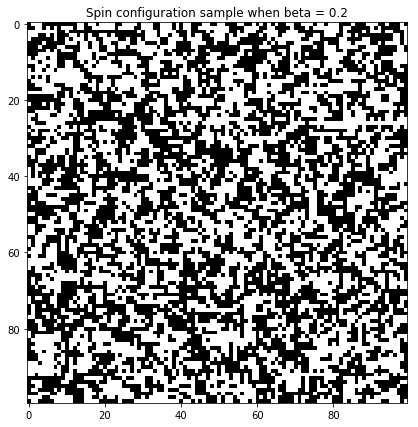

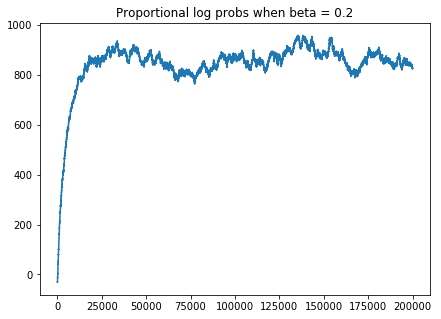

Acceptance rate 0.693


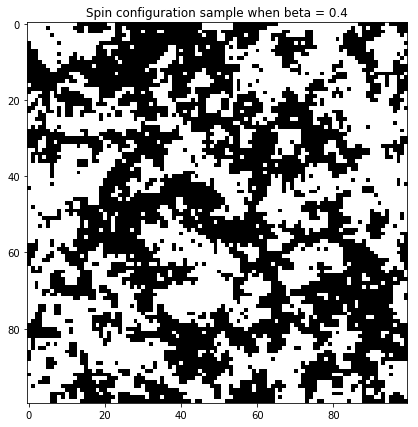

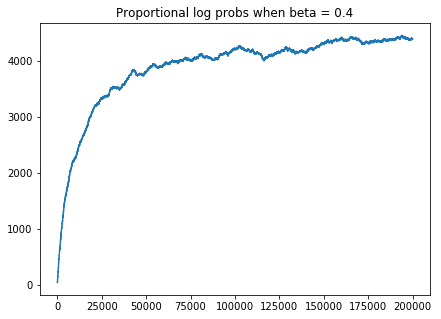

Acceptance rate 0.327


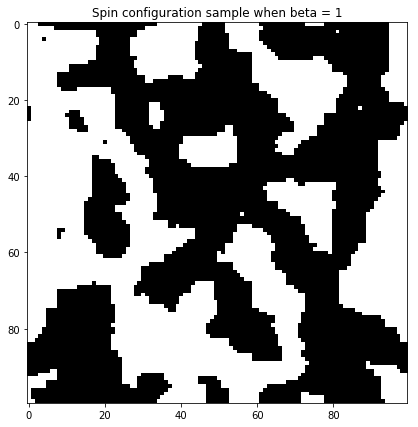

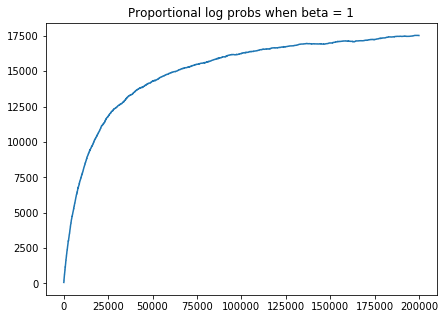

Acceptance rate 0.0632


In [147]:
betas = [.2, .4, 1]
L = []
for b in betas:
    lattices, energies, prop = ising_metropolis(beta = b)
    plt.figure(figsize=(7,7))
    plt.title(f"Spin configuration sample when beta = {b}")
    plt.imshow(lattices[-1], cmap='gray')
    plt.show()
    plt.figure(figsize=(7,5))
    plt.title(f"Proportional log probs when beta = {b}")
    plt.plot(np.arange(200000), energies)
    plt.show()
    print("Acceptance rate", prop)